In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import emot
emot_obj = emot.emot()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [2]:
current_dir = os.getcwd()
dataset_path = os.path.join(current_dir, 'dataset/school_review_sentiment.csv')
stopwords = os.path.join(current_dir, 'stopwords.txt')

df = pd.read_csv(
    dataset_path
)
print(df)

                                                sentence sentiment       topic
0              Này anh bạn, việc tấu hài là của tôi chứ!  positive      others
1      Phải công ngận ChatGPT thật sự hữu ích. Albert...  positive      others
2      Thế đến lúc ra trường em paste thẳng code vào ...  positive      others
3      mong là bạn không dùng chatgpt viết status này...   neutral      others
4                              không ai khác ngoài mr.10   neutral    lecturer
...                                                  ...       ...         ...
11196  Giáo viên đưa ra các phương tiện hỗ trợ giảng ...   neutral  curriculum
11197  The university's computer facilities are up-to...   neutral    facility
11198  Thiếu tính linh hoạt trong hình thức giảng dạy...  negative  curriculum
11199  Cô ấy rất sắc sảo và có khả năng phân tích chi...  positive      others
11200  Anh ấy có tài năng về âm nhạc và luôn tìm cách...  positive      others

[11201 rows x 3 columns]


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11201 entries, 0 to 11200
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentence   11201 non-null  object
 1   sentiment  11201 non-null  object
 2   topic      11201 non-null  object
dtypes: object(3)
memory usage: 262.6+ KB


In [4]:
df.describe()

,sentence,sentiment,topic
count,11201,11201,11201
unique,11104,4,8
top,Bài tập IoT làm nhóm vui vl 🤖 sản phẩm chạy mượt,positive,curriculum
freq,4,3809,2636


In [5]:
unique_sentiment = df['sentiment'].unique()
unique_topics = df['topic'].unique()

print(unique_sentiment)
print(unique_topics)

['positive' ' neutral' 'negative' 'neutral']
['others' 'lecturer' 'facility' 'curriculum' ' lecturer' ' facility'
 ' curriculum' ' others']


In [6]:
# Remove duplicate
df = df.drop_duplicates(subset='sentence')

# Strip leading/trailing whitespace in 'sentiment' and 'topic' columns
df['sentiment'] = df['sentiment'].str.strip()
df['topic'] = df['topic'].str.strip()

df.describe()

,sentence,sentiment,topic
count,11104,11104,11104
unique,11104,3,4
top,Thiếu sự đồng thuận giữa sinh viên và giảng vi...,negative,curriculum
freq,1,3770,2911


In [7]:
def text_normalize(text):
    #Lowercasing
    text = text.lower()
    
    # Hyperlinks removal
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
    
    # Punctuation removal
    text = re.sub(r'[^\w\s]', '', text)
    
    #Remove stopwords
    stopwords_txt = pd.read_csv(stopwords, header=None)
    stop_words = stopwords_txt[0].tolist()
    words = text.split()
    words = [word for word in words if word not in stop_words]
    text = ' '.join(words)                                          # Space handling
    return text

# remove emoticons to using emot
def handle_emoticons(text, remove_emoticon=True):
    dict_emoticons = dict(zip(emot_obj.emoticons(text)['value'], emot_obj.emoticons(text)['mean']))
    res_emoticons =  dict(sorted(dict_emoticons.items(), key = lambda kv:len(kv[1]), reverse=True))
    for emoticon, mean in res_emoticons.items():
        if remove_emoticon:
            text = text.replace(emoticon, "")
        else:
            text = text.replace(emoticon, mean)
    return text

def handle_emojis(text, remove_emoji=True):
    for emoji, mean in zip(emot_obj.emoji(text)['value'], emot_obj.emoji(text)['mean']):
        if remove_emoji:
            text = text.replace(emoji, "")
        else:
            text = text.replace(emoji, mean)
    return text


In [8]:
test = "Đồ án Cybersecurity 5000 dòng       code :))) team 3 đứa rụng tóc 🧑‍🦲"
test = text_normalize(test)
test = handle_emoticons(test)
test = handle_emojis(test)
print(test)

đồ án cybersecurity 5000 dòng code team 3 đứa rụng tóc


In [9]:
df['sentence'] = df['sentence'].apply(
    lambda x: text_normalize(x)
)

In [10]:
vectorizer = TfidfVectorizer(
    max_features=500
)

X = vectorizer.fit_transform(
    df['sentence']
).toarray()

In [11]:
print(X.shape)

(11104, 500)


In [12]:
### Convert sentiment and topic columns to numerical values

# Create dictionaries for sentiment and topic mapping
sentiment_dict = {'negative': 0, 'neutral': 1, 'positive': 2}
topic_dict = {'facility': 0, 'curriculum': 1, 'lecturer': 2, 'others': 3}

# Apply the transformation
df['sentiment'] = df['sentiment'].map(sentiment_dict)
df['topic'] = df['topic'].map(topic_dict)

# Display the first few rows with the new columns
print(df[['sentence', 'sentiment', 'topic']].head())

                                            sentence  sentiment  topic
0                       anh bạn việc tấu hài tôi chứ          2      3
1  phải công ngận chatgpt thật sự hữu ích albert ...          2      3
2  thế lúc trường em paste thẳng code production nhé          2      3
3   mong bạn dùng chatgpt viết status chứ kỹ năng đủ          1      3
4                                 ai khác ngoài mr10          1      2


In [13]:
df['senti_n_topic'] = [[a, b] for a, b in zip(df['sentiment'], df['topic'])]

In [14]:
# Create a mapping from list tuples to integers
unique_labels = np.sort(df['senti_n_topic'].apply(tuple).unique())
n_classes = len(unique_labels)
n_samples = len(df)

# Create a mapping dictionary
label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}

# Convert lists to tuples (hashable) and map to indices
y = np.array([label_to_idx[tuple(label)] for label in df['senti_n_topic']])
y = torch.tensor(y, dtype=torch.long)  # CrossEntropyLoss needs class indices


In [15]:
label_to_idx

{(0, 0): 0,
 (0, 1): 1,
 (0, 2): 2,
 (0, 3): 3,
 (1, 0): 4,
 (1, 1): 5,
 (1, 2): 6,
 (1, 3): 7,
 (2, 0): 8,
 (2, 1): 9,
 (2, 2): 10,
 (2, 3): 11}

In [16]:
df

,sentence,sentiment,topic,senti_n_topic
0,anh bạn việc tấu hài tôi chứ,2,3,"[2, 3]"
1,phải công ngận chatgpt thật sự hữu ích albert ...,2,3,"[2, 3]"
2,thế lúc trường em paste thẳng code production nhé,2,3,"[2, 3]"
3,mong bạn dùng chatgpt viết status chứ kỹ năng đủ,1,3,"[1, 3]"
4,ai khác ngoài mr10,1,2,"[1, 2]"
...,...,...,...,...
11196,giáo viên đưa phương tiện hỗ trợ giảng dạy tốt...,1,1,"[1, 1]"
11197,the universitys computer facilities are uptoda...,1,0,"[1, 0]"
11198,thiếu tính linh hoạt hình thức giảng dạy đánh ...,0,1,"[0, 1]"
11199,cô ấy sắc sảo khả năng phân tích chi tiết tốt,2,3,"[2, 3]"


In [17]:
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

C:\Users\vinht\AppData\Local\Temp\ipykernel_19228\3998235742.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.long)


In [18]:
val_size = 0.2
test_size = 0.1
random_state = 42
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=val_size,
    random_state=random_state,
    shuffle=is_shuffle
)

X_val, X_test, y_val, y_test = train_test_split(
    X_val, y_val,
    test_size=test_size,
    random_state=random_state,
    shuffle=is_shuffle
)

In [19]:
print(f'Number of training samples: {X_train.shape[0]}')
print(f'Number of val samples: {X_val.shape[0]}')
print(f'Number of test samples: {X_test.shape[0]}')

Number of training samples: 8883
Number of val samples: 1998
Number of test samples: 223


In [20]:
class SoftmaxRegressionWithHidden(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SoftmaxRegressionWithHidden, self).__init__()
        self.output = nn.Linear(input_dim, output_dim)
        
    def forward(self, x):
        return self.output(x)

In [21]:
def compute_accuracy(y_hat, y_true):
    y_hat = torch.argmax(y_hat, dim=1)  # Convert logits to predicted class indices
    
    correct = (y_hat == y_true).sum().item()  # Compare with ground truth
    accuracy = correct / y_true.size(0)  # Normalize accuracy

    return accuracy

In [22]:
lr = 0.01
epochs = 10000

input_dim = X_train.shape[1]
output_dim = len(unique_labels)  # Number of unique sentiment-topic pairs

model = SoftmaxRegressionWithHidden(
    input_dim, output_dim
)
model = model.to(device=device)

criterion = nn.CrossEntropyLoss()       # SOFTMAX REGRESSION APPLIED here
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-6)

In [23]:
train_losses = []
train_accs = []
val_losses = []
val_accs = []

# Move data to the same device as the model
X_train = X_train.to(device)
y_train = y_train.to(device)
X_val = X_val.to(device)
y_val = y_val.to(device)

for epoch in range(epochs):
    model.train()
    
    optimizer.zero_grad()
    
    y_hat = model(X_train)
    
    train_loss = criterion(y_hat, y_train)
    train_losses.append(train_loss.item())
    
    train_acc = compute_accuracy(y_hat, y_train)
    train_accs.append(train_acc)
    
    train_loss.backward()
    optimizer.step()
    
    model.eval()
    with torch.no_grad():
        y_val_hat = model(X_val)
        
        val_loss = criterion(y_val_hat, y_val)
        val_losses.append(val_loss.item())
        
        val_acc = compute_accuracy(y_val_hat, y_val)
        val_accs.append(val_acc)
    
    print(f'\nEPOCH {epoch + 1}:\tTraining loss: {train_loss:.3f}\tValidation loss: {val_loss:.3f}')    
    


EPOCH 1:	Training loss: 2.487	Validation loss: 2.485

EPOCH 2:	Training loss: 2.485	Validation loss: 2.482

EPOCH 3:	Training loss: 2.482	Validation loss: 2.480

EPOCH 4:	Training loss: 2.480	Validation loss: 2.478

EPOCH 5:	Training loss: 2.477	Validation loss: 2.476

EPOCH 6:	Training loss: 2.475	Validation loss: 2.474

EPOCH 7:	Training loss: 2.473	Validation loss: 2.471

EPOCH 8:	Training loss: 2.470	Validation loss: 2.469

EPOCH 9:	Training loss: 2.468	Validation loss: 2.467

EPOCH 10:	Training loss: 2.466	Validation loss: 2.465

EPOCH 11:	Training loss: 2.463	Validation loss: 2.463

EPOCH 12:	Training loss: 2.461	Validation loss: 2.461

EPOCH 13:	Training loss: 2.458	Validation loss: 2.458

EPOCH 14:	Training loss: 2.456	Validation loss: 2.456

EPOCH 15:	Training loss: 2.454	Validation loss: 2.454

EPOCH 16:	Training loss: 2.451	Validation loss: 2.452

EPOCH 17:	Training loss: 2.449	Validation loss: 2.450

EPOCH 18:	Training loss: 2.447	Validation loss: 2.448

EPOCH 19:	Training

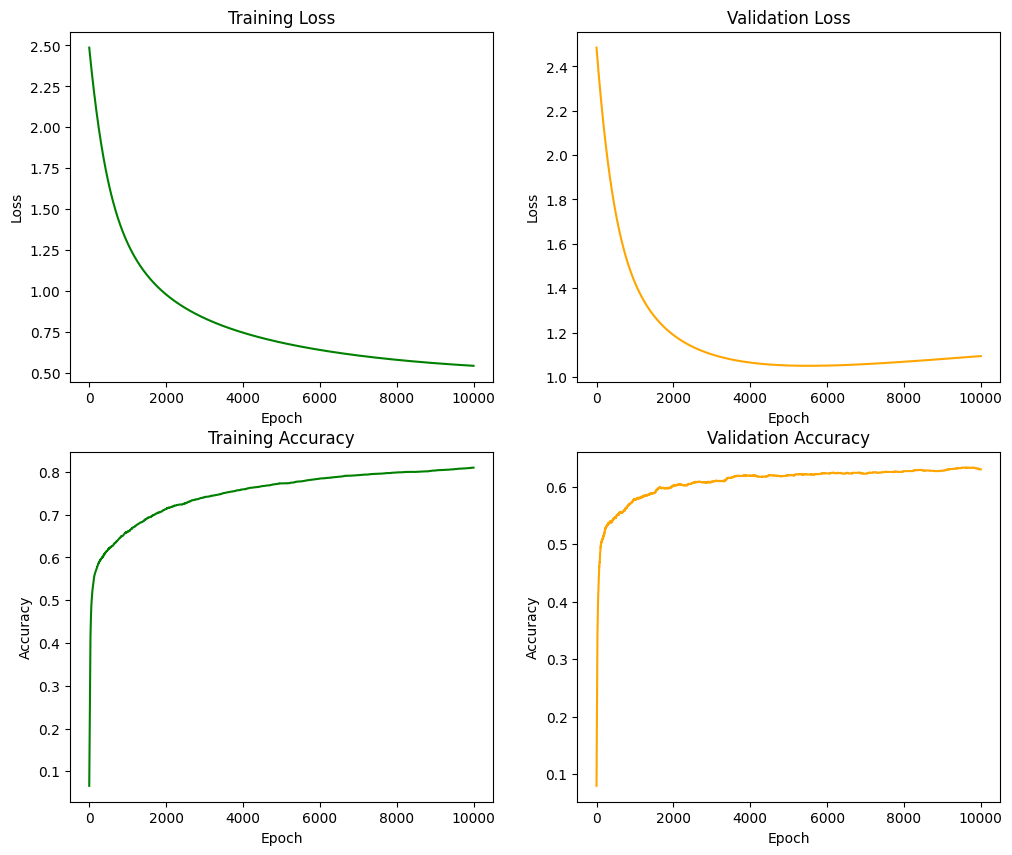

In [24]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_losses, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_accs, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_accs, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

In [25]:
# Val set
model.eval()
with torch.no_grad():
    y_hat = model(X_val)
    val_set_acc = compute_accuracy(y_hat, y_val)
    print('Evaluation on validation set:')
    print(f'Accuracy: {val_set_acc}')

Evaluation on validation set:
Accuracy: 0.6301301301301301


In [26]:
# Test set
model.eval()
with torch.no_grad():
    # Move test data to the same device as the model
    X_test = X_test.to(device)
    y_test = y_test.to(device)
    
    y_hat = model(X_test)
    test_set_acc = compute_accuracy(y_hat, y_test)
    print('Evaluation on test set:')
    print(f'Accuracy: {test_set_acc}')

Evaluation on test set:
Accuracy: 0.6322869955156951


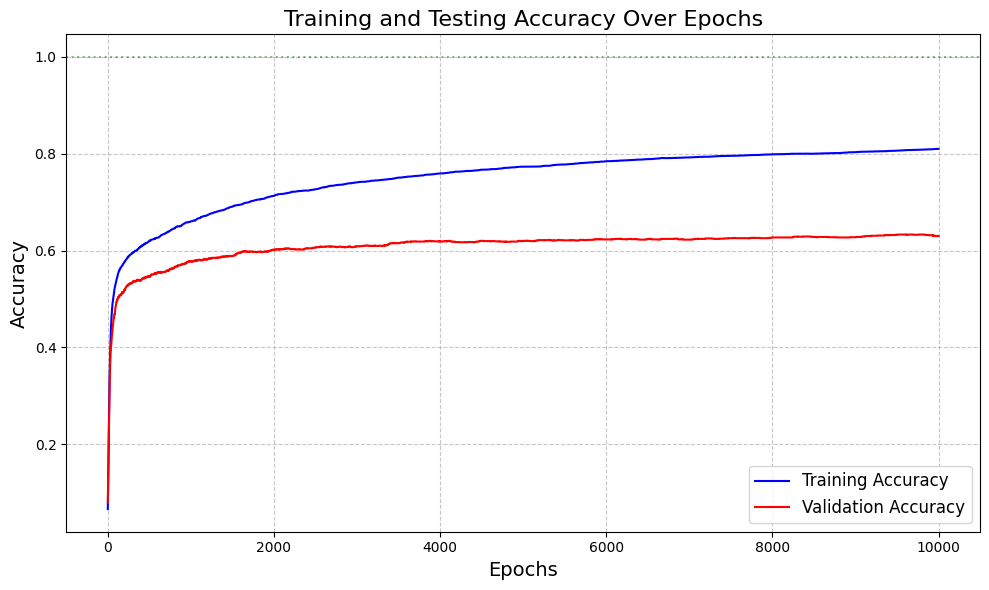

In [27]:
import matplotlib.pyplot as plt

# Use the train_accs and val_accs lists we already have from training
plt.figure(figsize=(10, 6))
plt.plot(train_accs, label='Training Accuracy', color='blue')
plt.plot(val_accs, label='Validation Accuracy', color='red')

plt.title('Training and Testing Accuracy Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)

# Add a horizontal line at 100% accuracy for reference
plt.axhline(y=1.0, color='green', linestyle=':', alpha=0.5)

# Improve visual appearance
plt.tight_layout()
plt.show()

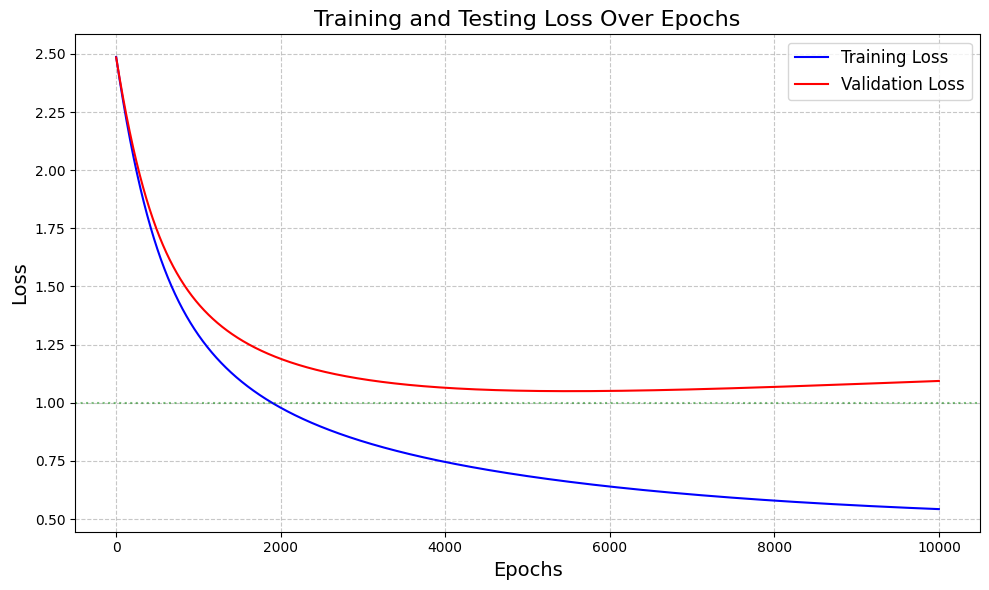

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='red')

plt.title('Training and Testing Loss Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)

plt.axhline(y=1.0, color='green', linestyle=':', alpha=0.5)

plt.tight_layout()
plt.show()